In [1]:
import pandas as pd
import numpy as np

ACADEMIC_PATH = r'../../data/raw/academic_records.csv'
ADMISSION_PATH = r'../../data/raw/admission.csv'
TEST_PATH = r'../../data/raw/test.csv'
academic_records = pd.read_csv(ACADEMIC_PATH)
admission = pd.read_csv(ADMISSION_PATH)

In [2]:
import pandas as pd
import numpy as np

def clean_data_pipeline(admission, academic_records):
    print("--- BẮT ĐẦU QUY TRÌNH LÀM SẠCH DỮ LIỆU ---")
    
    # =========================================================================
    # BƯỚC 1: XỬ LÝ ĐỊNH DẠNG & KIỂU DỮ LIỆU (Formatting)
    # =========================================================================
    print("Step 1: Formatting & Merging...")
    
    # 1.1. Chuẩn hóa MA_SO_SV về dạng String
    admission['MA_SO_SV'] = admission['MA_SO_SV'].astype(str)
    academic_records['MA_SO_SV'] = academic_records['MA_SO_SV'].astype(str)
    
    # 1.2. Chuyển đổi HOC_KY sang số nguyên (giả định hàm hoc_ky_to_code đã được định nghĩa bên ngoài)
    # Nếu chưa có hàm này, bạn cần định nghĩa logic convert (ví dụ: '20231' -> int)
    # academic_records['HOC_KY'] = academic_records['HOC_KY'].apply(hoc_ky_to_code)
    
    # Merge dữ liệu (Inner Join để chỉ lấy sinh viên có thông tin ở cả 2 bảng)
    df = pd.merge(academic_records, admission, on='MA_SO_SV', how='inner')
    
    # 1.3. Định dạng lại các cột số (Ép kiểu float/int)
    numeric_floats = ['GPA', 'CPA', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']
    for col in numeric_floats:
        df[col] = pd.to_numeric(df[col], errors='coerce') 
        
    numeric_ints = ['TC_DANGKY', 'TC_HOANTHANH']
    for col in numeric_ints:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Sắp xếp dữ liệu
    df = df.sort_values(by=['MA_SO_SV', 'HOC_KY']).reset_index(drop=True)

    # =========================================================================
    # BƯỚC 2: KIỂM TRA LOGIC & LÀM SẠCH NHIỄU (Sanity Checks)
    # =========================================================================
    print("Step 2: Sanity Checks & Logic Cleaning...")
    
    initial_rows = len(df)

    # 3.1. Logic Tín chỉ: Hoàn thành không được lớn hơn Đăng ký
    df['TC_HOANTHANH'] = np.minimum(df['TC_HOANTHANH'], df['TC_DANGKY'])
    
    # 3.2. Logic Điểm số (0 <= GPA/CPA <= 4.0)
    df['GPA'] = df['GPA'].clip(lower=0.0, upper=4.0)
    df['CPA'] = df['CPA'].clip(lower=0.0, upper=4.0)
    
    # -----------------------------------------------------------
    # [MỚI] 3.3. Logic Tuyển sinh: DIEM_TRUNGTUYEN >= DIEM_CHUAN
    # -----------------------------------------------------------
    # Loại bỏ các dòng mà điểm trúng tuyển nhỏ hơn điểm chuẩn.
    # Lưu ý: Các giá trị NaN (do lỗi format ở B1) cũng sẽ bị loại bỏ trong phép so sánh này.
    rows_before_score_filter = len(df)
    df = df[df['DIEM_TRUNGTUYEN'] >= df['DIEM_CHUAN']]
    dropped_score_rows = rows_before_score_filter - len(df)
    print(f" -> Đã loại bỏ {dropped_score_rows} dòng do Điểm trúng tuyển < Điểm chuẩn.")

    # 3.4. Xóa dữ liệu rác (TC_DANGKY = 0)
    rows_before_credit_filter = len(df)
    df = df[df['TC_DANGKY'] > 0].copy()
    dropped_credit_rows = rows_before_credit_filter - len(df)
    print(f" -> Đã loại bỏ {dropped_credit_rows} dòng rác (TC_DANGKY=0).")
    
    # Tổng kết
    total_dropped = initial_rows - len(df)
    print(f"--- HOÀN TẤT: Tổng cộng đã loại bỏ {total_dropped} dòng nhiễu. Kích thước data cuối: {df.shape} ---")
    
    return df

In [3]:
df = clean_data_pipeline(admission, academic_records)

--- BẮT ĐẦU QUY TRÌNH LÀM SẠCH DỮ LIỆU ---
Step 1: Formatting & Merging...
Step 2: Sanity Checks & Logic Cleaning...
 -> Đã loại bỏ 0 dòng do Điểm trúng tuyển < Điểm chuẩn.
 -> Đã loại bỏ 0 dòng rác (TC_DANGKY=0).
--- HOÀN TẤT: Tổng cộng đã loại bỏ 0 dòng nhiễu. Kích thước data cuối: (105726, 11) ---


In [4]:
df.head()

,MA_SO_SV,HOC_KY,CPA,GPA,TC_DANGKY,TC_HOANTHANH,NAM_TUYENSINH,PTXT,TOHOP_XT,DIEM_TRUNGTUYEN,DIEM_CHUAN
0,00003e092652,HK1 2023-2024,1.64,1.97,18,15,2023,100,A00,21.32,20.25
1,00003e092652,HK2 2023-2024,1.53,2.05,18,13,2023,100,A00,21.32,20.25
2,000e15519006,HK1 2021-2022,3.85,3.85,9,9,2021,1,D07,23.84,22.43
3,000e15519006,HK1 2022-2023,2.83,2.98,21,21,2021,1,D07,23.84,22.43
4,000e15519006,HK1 2023-2024,1.50,2.73,20,14,2021,1,D07,23.84,22.43


In [5]:
def parse_semester_code(semester_code):
    parts = semester_code.strip().split()
    semester = int(parts[0].replace('HK', ''))
    year_range = parts[1].split('-')
    year = int(year_range[0])
    return year, semester


def get_semester_order(semester_code):
    year, semester = parse_semester_code(semester_code)
    return year * 10 + semester


In [6]:
def split_data(merged_df, train_end='HK1 2023-2024', valid_semester='HK2 2023-2024'):
    print("Splitting data into train and validation sets...")
    merged_df['semester_order'] = merged_df['HOC_KY'].apply(get_semester_order)
    train_end_order = get_semester_order(train_end)
    valid_order = get_semester_order(valid_semester)
    train_df = merged_df[merged_df['semester_order'] <= train_end_order].copy()
    valid_df = merged_df[merged_df['semester_order'] == valid_order].copy()    
    print(f"Train data: {train_df.shape}")
    print(f"Valid data: {valid_df.shape}")
        
    return train_df, valid_df

In [7]:
train, valid = split_data(df)

Splitting data into train and validation sets...
Train data: (90582, 12)
Valid data: (15144, 12)


In [8]:
train.head()

,MA_SO_SV,HOC_KY,CPA,GPA,TC_DANGKY,TC_HOANTHANH,NAM_TUYENSINH,PTXT,TOHOP_XT,DIEM_TRUNGTUYEN,DIEM_CHUAN,semester_order
0,00003e092652,HK1 2023-2024,1.64,1.97,18,15,2023,100,A00,21.32,20.25,20231
2,000e15519006,HK1 2021-2022,3.85,3.85,9,9,2021,1,D07,23.84,22.43,20211
3,000e15519006,HK1 2022-2023,2.83,2.98,21,21,2021,1,D07,23.84,22.43,20221
4,000e15519006,HK1 2023-2024,1.50,2.73,20,14,2021,1,D07,23.84,22.43,20231
5,000e15519006,HK2 2021-2022,2.77,3.12,19,19,2021,1,D07,23.84,22.43,20212


In [10]:
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

def encode_categorical_features(X, categorical_cols, label_encoders=None, is_training=True):
    # Luôn tạo bản sao để tránh SettingWithCopyWarning
    X = X.copy()
    
    if label_encoders is None:
        label_encoders = {}
        
    for col in categorical_cols:
        if col in X.columns:
            # Chuyển hết về string để tránh lỗi mixed types
            X[col] = X[col].astype(str)
            
            if is_training:
                le = LabelEncoder()
                # Fit trên tập train
                le.fit(X[col])
                # Transform và lưu lại encoder
                X[col] = le.transform(X[col])
                label_encoders[col] = le
            else:
                le = label_encoders.get(col)
                if le is not None:
                    # Lấy danh sách các class đã học
                    classes = set(le.classes_)
                    
                    # LOGIC SỬA ĐỔI: Thay vì hack le.classes_, ta dùng map
                    # Những giá trị lạ -> gán về 'Unknown' (hoặc giữ nguyên để map thành -1)
                    # Cách an toàn nhất cho XGBoost: Gán Unknown thành -1
                    X[col] = X[col].apply(lambda x: x if x in classes else '<Unknown>')
                    
                    # Nếu '<Unknown>' chưa có trong encoder, ta cần xử lý thủ công
                    # Cách đơn giản: Map thủ công bằng dictionary của le
                    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
                    
                    # Map dữ liệu: Nếu không tìm thấy key, trả về -1
                    X[col] = X[col].map(lambda x: le_dict.get(x, -1))
            
            # QUAN TRỌNG: Chuyển sang kiểu 'category' để XGBoost (enable_categorical=True) hiểu đúng
            X[col] = X[col].astype('category')

    return X, label_encoders

# --- PHẦN CHẠY THỬ ---

# 1. Định nghĩa feature
feature_cols = [
    'CPA', 'GPA', 'TC_DANGKY', 
    'NAM_TUYENSINH', 'PTXT', 'TOHOP_XT', 
    'DIEM_TRUNGTUYEN', 'DIEM_CHUAN'
]
categorical_cols = ['PTXT', 'TOHOP_XT']

# 2. Chuẩn bị dữ liệu train
X_train = train[feature_cols]
X_valid = valid[feature_cols]
y_train = train['TC_HOANTHANH']  # Target riêng biệt
y_valid = valid['TC_HOANTHANH']

# Lưu ý: X_train_enc sẽ có các cột category dạng số hoặc -1
X_train_enc, label_encoders = encode_categorical_features(X_train, categorical_cols, is_training=True)
X_valid_enc, _ = encode_categorical_features(X_valid, categorical_cols, label_encoders, is_training=False)

# 3. Train model
# tree_method='hist' thường được yêu cầu khi dùng enable_categorical
model = xgb.XGBRegressor(
    enable_categorical=True, 
    tree_method='hist',  # Bắt buộc để tối ưu hoá việc xử lý category
    missing=-1           # Báo cho XGBoost biết -1 là giá trị rỗng/lạ (Unknown)
)

model.fit(
    X_train_enc, y_train, 
    eval_set=[(X_valid_enc, y_valid)], 
    verbose=True
)

print("Train xong!")

[0]	validation_0-rmse:5.15918
[1]	validation_0-rmse:3.79623
[2]	validation_0-rmse:2.89506
[3]	validation_0-rmse:2.31510
[4]	validation_0-rmse:1.95523
[5]	validation_0-rmse:1.73102
[6]	validation_0-rmse:1.59965
[7]	validation_0-rmse:1.52438
[8]	validation_0-rmse:1.48347
[9]	validation_0-rmse:1.46086
[10]	validation_0-rmse:1.44358
[11]	validation_0-rmse:1.43605
[12]	validation_0-rmse:1.42810
[13]	validation_0-rmse:1.42478
[14]	validation_0-rmse:1.42612
[15]	validation_0-rmse:1.42704
[16]	validation_0-rmse:1.42623
[17]	validation_0-rmse:1.42724
[18]	validation_0-rmse:1.42867
[19]	validation_0-rmse:1.42905
[20]	validation_0-rmse:1.42974
[21]	validation_0-rmse:1.43238
[22]	validation_0-rmse:1.43207
[23]	validation_0-rmse:1.43455
[24]	validation_0-rmse:1.43533
[25]	validation_0-rmse:1.43603
[26]	validation_0-rmse:1.43577
[27]	validation_0-rmse:1.43494
[28]	validation_0-rmse:1.43498
[29]	validation_0-rmse:1.43545
[30]	validation_0-rmse:1.43681
[31]	validation_0-rmse:1.43784
[32]	validation_0-

In [19]:
import pandas as pd
import numpy as np
from scipy.stats import linregress

# --- 1. CÁC HÀM BỔ TRỢ (HELPER FUNCTIONS) ---

def parse_semester_code(semester_code):
    """Tách học kỳ và năm học từ chuỗi (VD: 'HK1 2023-2024')"""
    if pd.isna(semester_code):
        return 0, 0
    try:
        parts = str(semester_code).strip().split()
        semester = int(parts[0].replace('HK', ''))
        year_part = parts[1].split('-')[0]
        year = int(year_part)
        return year, semester
    except:
        return 0, 0

def calculate_semester_from_admission(admission_year, semester_code):
    """Tính sinh viên đang học ở kỳ thứ mấy kể từ khi nhập học"""
    if pd.isna(admission_year) or pd.isna(semester_code):
        return 0
    
    current_year, current_sem = parse_semester_code(semester_code)
    if current_year == 0:
        return 0
    semester_num = (current_year - admission_year) * 2 + current_sem
    return max(1, semester_num)

def fast_slope(y):
    """Tính hệ số góc (Trend)"""
    if len(y) < 2:
        return 0.0
    x = np.arange(len(y))
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    numerator = np.sum((x - x_mean) * (y - y_mean))
    denominator = np.sum((x - x_mean) ** 2)
    return numerator / (denominator + 1e-6)

# --- 2. FEATURE ENGINEER CLASS (ĐÃ SỬA DATA LEAKAGE) ---

class FeatureEngineer:    
    def __init__(self):
        self.feature_names = []
        
    def create_features(self, df, is_training=True):
        df = df.copy()
        
        # 1. Sắp xếp dữ liệu theo thời gian (BẮT BUỘC)
        if 'HOC_KY' in df.columns:
            df['sem_year'] = df['HOC_KY'].apply(lambda x: parse_semester_code(x)[0])
            df['sem_no'] = df['HOC_KY'].apply(lambda x: parse_semester_code(x)[1])
            df['semester_order'] = df['sem_year'] * 10 + df['sem_no']
            
            if 'MA_SO_SV' in df.columns:
                df = df.sort_values(['MA_SO_SV', 'semester_order'])
        
        # ---------------------------------------------------------
        # [QUAN TRỌNG NHẤT] TẠO LAG FEATURES (DỮ LIỆU QUÁ KHỨ)
        # Tất cả feature sau này phải dùng các cột Prev_ này
        # ---------------------------------------------------------
        grouped = df.groupby('MA_SO_SV')
        
        # Lấy thông tin của kỳ liền trước (Shift 1)
        df['Prev_GPA'] = grouped['GPA'].shift(1).fillna(0)
        df['Prev_CPA'] = grouped['CPA'].shift(1).fillna(0)
        df['Prev_TC_HOANTHANH'] = grouped['TC_HOANTHANH'].shift(1).fillna(0)
        df['Prev_TC_DANGKY'] = grouped['TC_DANGKY'].shift(1).fillna(0)
        
        # ---------------------------------------------------------
        
        # Pipeline tạo feature (Đã sửa logic bên trong để dùng Prev_)
        df = self._create_admission_features(df)
        df = self._create_history_features(df)     # Thay thế academic features cũ
        df = self._create_temporal_features(df)
        df = self._create_trend_features(df)       # Trend dựa trên lịch sử
        
        # Dọn dẹp cột tạm
        df = df.drop(columns=['sem_year', 'sem_no'], errors='ignore')
        
        return df
    
    def _create_admission_features(self, df):
        # Thông tin tĩnh (không đổi) -> Giữ nguyên được
        if 'DIEM_TRUNGTUYEN' in df.columns and 'DIEM_CHUAN' in df.columns:
            df['diem_vuot_chuan'] = df['DIEM_TRUNGTUYEN'] - df['DIEM_CHUAN']
        
        if 'NAM_TUYENSINH' in df.columns:
            current_year = 2024 
            df['nam_tuoi'] = current_year - df['NAM_TUYENSINH']
        return df
    
    def _create_history_features(self, df):
        """Tạo feature dựa trên kết quả kỳ trước (Prev_)"""
        
        # 1. So sánh GPA kỳ trước và CPA tích lũy
        df['prev_gpa_cpa_diff'] = df['Prev_GPA'] - df['Prev_CPA']
        
        # 2. Phân loại học lực KỲ TRƯỚC
        df['prev_gpa_excellent'] = (df['Prev_GPA'] >= 3.6).astype(int)
        df['prev_gpa_good'] = ((df['Prev_GPA'] >= 3.2) & (df['Prev_GPA'] < 3.6)).astype(int)
        df['prev_gpa_poor'] = (df['Prev_GPA'] < 2.5).astype(int)
        
        # 3. Tỷ lệ hoàn thành KỲ TRƯỚC (Completion Rate Lag 1)
        df['prev_completion_rate'] = df['Prev_TC_HOANTHANH'] / (df['Prev_TC_DANGKY'] + 0.01)
        
        # 4. Cảnh báo rớt môn kỳ trước
        df['failed_last_sem'] = (df['Prev_TC_HOANTHANH'] < df['Prev_TC_DANGKY']).astype(int)
        
        # 5. [Mới] Đăng ký so với năng lực cũ
        # Kỳ này đăng ký bao nhiêu so với kỳ trước đã làm được
        if 'TC_DANGKY' in df.columns:
            df['load_vs_prev_capacity'] = df['TC_DANGKY'] / (df['Prev_TC_HOANTHANH'] + 1)
            
            # Flag: Kỳ trước rớt môn nhưng kỳ này đăng ký nhiều hơn (Nóng vội)
            df['aggressive_recovery'] = (
                (df['failed_last_sem'] == 1) & 
                (df['TC_DANGKY'] > df['Prev_TC_DANGKY'])
            ).astype(int)
            
        return df
    
    def _create_temporal_features(self, df):        
        if 'HOC_KY' in df.columns and 'NAM_TUYENSINH' in df.columns:
            df['semester_number'] = df.apply(
                lambda row: calculate_semester_from_admission(
                    row['NAM_TUYENSINH'], 
                    row['HOC_KY']
                ), axis=1
            )
            df['is_semester_2'] = df['HOC_KY'].apply(lambda x: 1 if 'HK2' in str(x) else 0)
        return df

    def _create_trend_features(self, df):
        """Tính xu hướng dựa trên lịch sử (Prev_GPA)"""
        # Lưu ý: Rolling ở đây phải tính trên Prev_GPA để không lộ đề
        if 'Prev_GPA' in df.columns:
            # Tính Slope của 3 kỳ gần nhất (dựa trên điểm đã có)
            df['gpa_trend_slope'] = df.groupby('MA_SO_SV')['Prev_GPA'].transform(
                lambda x: x.rolling(window=3, min_periods=2).apply(fast_slope, raw=True)
            ).fillna(0)
            
            # Trung bình GPA 3 kỳ gần nhất
            df['avg_prev_gpa_3sem'] = df.groupby('MA_SO_SV')['Prev_GPA'].transform(
                lambda x: x.rolling(window=3, min_periods=1).mean()
            ).fillna(0)

        # Tính tổng tín chỉ tích lũy (Dựa trên Prev_TC_HOANTHANH)
        # cumsum() của Prev_TC_HOANTHANH chính là tổng tín chỉ tính đến đầu kỳ này
        if 'Prev_TC_HOANTHANH' in df.columns:
            df['accumulated_credits'] = df.groupby('MA_SO_SV')['Prev_TC_HOANTHANH'].cumsum()
            
        return df
    
    def get_feature_columns(self, df, exclude_cols=None):
        """
        Chọn lọc feature an toàn.
        Tuyệt đối loại bỏ GPA, CPA, TC_HOANTHANH gốc.
        """
        # Danh sách các cột feature hợp lệ (White-list strategy an toàn hơn)
        valid_prefixes = ['Prev_', 'prev_', 'sem_', 'diem_', 'nam_', 'is_', 'failed_', 'load_', 'aggressive_', 'avg_', 'accumulated_', 'gpa_trend']
        valid_exact = ['TC_DANGKY', 'NAM_TUYENSINH', 'PTXT', 'TOHOP_XT', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'semester_number']
        
        final_cols = []
        for col in df.columns:
            # 1. Phải là số hoặc category
            if not (pd.api.types.is_numeric_dtype(df[col]) or isinstance(df[col].dtype, pd.CategoricalDtype)):
                continue
                
            # 2. Kiểm tra tên cột
            is_valid = False
            if col in valid_exact:
                is_valid = True
            else:
                for prefix in valid_prefixes:
                    if col.startswith(prefix):
                        is_valid = True
                        break
            
            # 3. Loại bỏ các cột 'đáp án'
            if col in ['TC_HOANTHANH', 'GPA', 'CPA', 'semester_order']:
                is_valid = False
                
            if is_valid:
                final_cols.append(col)
                
        return final_cols

# --- 3. KIỂM TRA (TEST RUN) ---

print("Đang tạo features (Clean Version)...")
engineer = FeatureEngineer()

# Giả sử train và valid của bạn đã được load
# Lưu ý: Để tạo Lag Feature tốt nhất, nên gộp train+valid lại, tạo feature xong mới split
# Nhưng nếu chạy riêng thì chấp nhận kỳ đầu của valid bị thiếu lag 1 chút
full_df = pd.concat([train, valid]) 
full_df_fe = engineer.create_features(full_df)

# Split lại sau khi feature engineering để đảm bảo tính liên tục của lịch sử
# (Logic split này dựa trên semester_order như code cũ của bạn)
train_end_order = 20231 # Ví dụ HK1 2023-2024
train_fe = full_df_fe[full_df_fe['semester_order'] <= train_end_order].copy()
valid_fe = full_df_fe[full_df_fe['semester_order'] > train_end_order].copy()

# Lấy danh sách feature
feature_cols = engineer.get_feature_columns(train_fe)

print(f"Số lượng features: {len(feature_cols)}")
print("Danh sách features:", feature_cols)

# Kiểm tra xem có cột 'GPA' hay 'TC_HOANTHANH' lọt vào không
leakage_check = [col for col in feature_cols if col in ['GPA', 'CPA', 'TC_HOANTHANH']]
if len(leakage_check) > 0:
    print(f"CẢNH BÁO: Vẫn còn biến leakage: {leakage_check}")
else:
    print("AN TOÀN: Không phát hiện biến leakage.")

# Chuẩn bị dữ liệu
X_train = train_fe[feature_cols]
y_train = train_fe['TC_HOANTHANH']
X_valid = valid_fe[feature_cols]
y_valid = valid_fe['TC_HOANTHANH']

print("\nDữ liệu đã sẵn sàng! Bạn có thể đưa vào XGBoost.")

Đang tạo features (Clean Version)...
Số lượng features: 23
Danh sách features: ['TC_DANGKY', 'NAM_TUYENSINH', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'Prev_GPA', 'Prev_CPA', 'Prev_TC_HOANTHANH', 'Prev_TC_DANGKY', 'diem_vuot_chuan', 'nam_tuoi', 'prev_gpa_cpa_diff', 'prev_gpa_excellent', 'prev_gpa_good', 'prev_gpa_poor', 'prev_completion_rate', 'failed_last_sem', 'load_vs_prev_capacity', 'aggressive_recovery', 'semester_number', 'is_semester_2', 'gpa_trend_slope', 'avg_prev_gpa_3sem', 'accumulated_credits']
AN TOÀN: Không phát hiện biến leakage.

Dữ liệu đã sẵn sàng! Bạn có thể đưa vào XGBoost.


--- Bắt đầu training... ---
[0]	validation_0-rmse:6.48335	validation_1-rmse:7.06055
[1]	validation_0-rmse:6.44088	validation_1-rmse:7.01483
[2]	validation_0-rmse:6.39866	validation_1-rmse:6.97016
[3]	validation_0-rmse:6.35695	validation_1-rmse:6.92618
[4]	validation_0-rmse:6.32690	validation_1-rmse:6.90145
[5]	validation_0-rmse:6.28834	validation_1-rmse:6.86159
[6]	validation_0-rmse:6.24748	validation_1-rmse:6.81835
[7]	validation_0-rmse:6.20760	validation_1-rmse:6.77586
[8]	validation_0-rmse:6.16831	validation_1-rmse:6.73375
[9]	validation_0-rmse:6.12962	validation_1-rmse:6.69223
[10]	validation_0-rmse:6.09188	validation_1-rmse:6.65264
[11]	validation_0-rmse:6.05367	validation_1-rmse:6.61285
[12]	validation_0-rmse:6.01627	validation_1-rmse:6.57339
[13]	validation_0-rmse:5.97923	validation_1-rmse:6.53333
[14]	validation_0-rmse:5.94288	validation_1-rmse:6.49499
[15]	validation_0-rmse:5.90871	validation_1-rmse:6.45992
[16]	validation_0-rmse:5.87315	validation_1-rmse:6.42274
[17]	validati

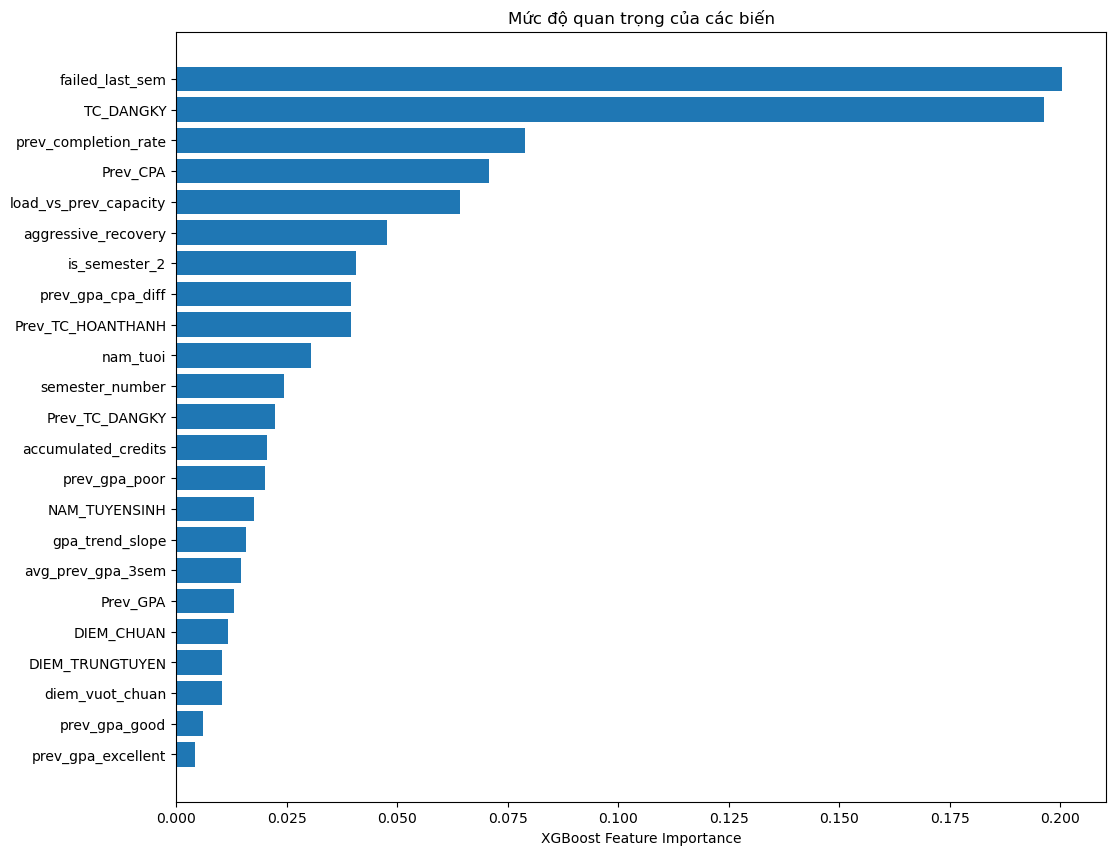

In [23]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Cấu hình mô hình (Hyperparameters)
model = xgb.XGBRegressor(
    n_estimators=1000,       # Số lượng cây tối đa (để lớn, dùng early_stopping để cắt)
    learning_rate=0.01,      # Tốc độ học (thấp thì học kỹ hơn nhưng lâu hơn)
    max_depth=10,             # Độ sâu của cây (càng sâu càng dễ overfit)
    subsample=0.9,           # Chỉ dùng 80% dữ liệu mỗi lần học để tránh học vẹt
    colsample_bytree=0.8,    # Chỉ dùng 80% số cột mỗi lần học
    
    # CÁC THAM SỐ QUAN TRỌNG CHO DỮ LIỆU CỦA BẠN
    enable_categorical=True, # Bật chế độ xử lý category (cho các cột PTXT, TOHOP...)
    tree_method='hist',      # Bắt buộc khi dùng enable_categorical
    missing=-1,              # Báo cho model biết -1 là giá trị rỗng (do bước encode tạo ra)
    
    random_state=42,
    n_jobs=-1                # Dùng hết CPU để chạy cho nhanh
)

# 2. Huấn luyện (Training)
print("--- Bắt đầu training... ---")
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)], # Theo dõi lỗi trên cả train và valid
    # early_stopping_rounds=50, # Nếu sau 50 vòng mà lỗi trên valid không giảm -> Dừng lại
    verbose=True               # In kết quả sau mỗi 100 vòng
)

# 3. Đánh giá kết quả (Evaluation)
print("\n--- Kết quả đánh giá ---")
# Dự đoán trên tập valid
preds = model.predict(X_valid)

# Tính toán sai số
# RMSE: Sai số trung bình bình phương (đơn vị cùng với target)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
# MAE: Sai số tuyệt đối trung bình (dễ hiểu hơn: lệch trung bình bao nhiêu tín chỉ)
mae = mean_absolute_error(y_valid, preds)

print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"MAE (Mean Absolute Error):      {mae:.4f}")
print(f"-> Trung bình model dự đoán lệch khoảng {mae:.2f} tín chỉ so với thực tế.")

# 4. Xem Feature Importance (Biến nào quan trọng nhất?)
# Giúp bạn biết các biến phái sinh (trend, slope...) có tác dụng không
plt.figure(figsize=(12, 10))
sorted_idx = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")
plt.title("Mức độ quan trọng của các biến")
plt.show()

In [24]:
def prepare_test_data(test_path, train_fe_df, admission_df):
    print("--- Đang xử lý dữ liệu Test ---")
    
    # 1. Đọc file test
    test_df = pd.read_csv(test_path)
    print(f"Kích thước file test gốc: {test_df.shape}")
    
    # Chuẩn hóa MA_SO_SV
    test_df['MA_SO_SV'] = test_df['MA_SO_SV'].astype(str)
    
    # 2. Lấy thông tin Tĩnh (Admission) - Nếu test chưa có
    # Merge với admission gốc hoặc lấy từ train
    cols_admission = ['MA_SO_SV', 'NAM_TUYENSINH', 'PTXT', 'TOHOP_XT', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']
    # Chỉ lấy các cột chưa có trong test
    cols_to_merge = [c for c in cols_admission if c not in test_df.columns and c != 'MA_SO_SV']
    
    if cols_to_merge:
        # Lấy thông tin admission duy nhất cho mỗi SV
        admission_info = train_fe_df[['MA_SO_SV'] + cols_to_merge].drop_duplicates('MA_SO_SV')
        test_df = test_df.merge(admission_info, on='MA_SO_SV', how='left')
    
    # 3. Lấy thông tin Động (Trạng thái học tập kỳ gần nhất)
    # Sắp xếp train theo thời gian để lấy dòng cuối cùng của mỗi sinh viên
    # train_fe_df cần là dataframe ĐÃ qua feature engineering ở bước trước
    last_state = train_fe_df.sort_values(['MA_SO_SV', 'semester_order']).groupby('MA_SO_SV').last().reset_index()
    
    # Các cột cần lấy từ quá khứ để làm feature cho hiện tại
    # Lưu ý: total_tc_completed của kỳ trước chính là total_tc_completed_lag1 của kỳ này
    cols_history_map = {
        'CPA': 'CPA',           # Giả định CPA không đổi nhiều hoặc dùng làm proxy
        'GPA': 'GPA_last',      # Lưu lại GPA kỳ trước để tham khảo (nếu cần)
        'total_tc_completed': 'total_tc_completed_lag1', # Tích lũy kỳ trước -> Lag 1 kỳ này
        'avg_gpa': 'avg_gpa_lag1',
        'avg_completion_rate': 'avg_completion_rate_lag1'
    }
    
    # Chỉ merge những cột có trong last_state
    available_cols = [c for c in cols_history_map.keys() if c in last_state.columns]
    
    last_state_subset = last_state[['MA_SO_SV'] + available_cols].copy()
    
    # Đổi tên cột cho đúng ý nghĩa Lag
    rename_dict = {k: v for k, v in cols_history_map.items() if k in available_cols}
    last_state_subset = last_state_subset.rename(columns=rename_dict)
    
    # Merge vào test
    test_df = test_df.merge(last_state_subset, on='MA_SO_SV', how='left')
    
    # 4. Xử lý các giá trị NaN (cho sinh viên mới hoặc dữ liệu thiếu)
    # Fill số bằng 0, fill category bằng 'Unknown' hoặc mode
    numeric_cols = ['CPA', 'total_tc_completed_lag1', 'avg_gpa_lag1', 'avg_completion_rate_lag1', 
                    'DIEM_TRUNGTUYEN', 'DIEM_CHUAN', 'NAM_TUYENSINH']
    for col in numeric_cols:
        if col in test_df.columns:
            test_df[col] = test_df[col].fillna(0)
            
    # [QUAN TRỌNG] Xử lý cột GPA cho Test
    # Nếu model train dùng GPA (kỳ hiện tại), ta không có GPA kỳ test.
    # Chiến thuật: Fill bằng GPA trung bình quá khứ (avg_gpa_lag1) hoặc CPA
    if 'GPA' not in test_df.columns and 'GPA' in train_fe_df.columns:
        print(" -> Tạo giả lập cột GPA từ CPA/Avg_GPA (Proxy) để model chạy được...")
        if 'avg_gpa_lag1' in test_df.columns:
            test_df['GPA'] = test_df['avg_gpa_lag1']
        elif 'CPA' in test_df.columns:
            test_df['GPA'] = test_df['CPA']
        else:
            test_df['GPA'] = 0.0

    print("Hoàn tất chuẩn bị dữ liệu Test.")
    return test_df

In [28]:
import pandas as pd
import numpy as np

# --- 1. CHUẨN BỊ LỊCH SỬ ĐẦY ĐỦ (CÓ FEATURE) ---
# Gộp train và valid để có lịch sử dài nhất
full_history = pd.concat([train_fe, valid_fe], ignore_index=True)

# --- 2. HÀM TẠO FEATURE CHO TEST (PHIÊN BẢN FIX LỖI) ---
def build_test_features_final(test_path, history_fe_df):
    print("--- Đang xử lý dữ liệu Test (Full Features) ---")
    test_df = pd.read_csv(test_path)
    test_df['MA_SO_SV'] = test_df['MA_SO_SV'].astype(str)
    
    # B1: Lấy thông tin tĩnh (Admission) từ lịch sử
    static_cols = ['MA_SO_SV', 'NAM_TUYENSINH', 'PTXT', 'TOHOP_XT', 'DIEM_TRUNGTUYEN', 'DIEM_CHUAN']
    admission_info = history_fe_df[static_cols].drop_duplicates('MA_SO_SV')
    test_df = test_df.merge(admission_info, on='MA_SO_SV', how='left')
    
    # B2: Lấy trạng thái MỚI NHẤT từ lịch sử
    # Sort để lấy dòng cuối cùng của mỗi sinh viên
    last_state = history_fe_df.sort_values(['MA_SO_SV', 'semester_order']).groupby('MA_SO_SV').last().reset_index()
    
    # --- LOGIC MERGE QUAN TRỌNG ---
    # Lấy giá trị của kỳ trước (Last) để làm đầu vào cho kỳ này (Test)
    # Ví dụ: GPA của kỳ cuối cùng trong lịch sử chính là Prev_GPA của kỳ Test
    rename_map = {
        'GPA': 'Prev_GPA',
        'CPA': 'Prev_CPA',
        'TC_HOANTHANH': 'Prev_TC_HOANTHANH',
        'TC_DANGKY': 'Prev_TC_DANGKY',
        # Lấy luôn các biến Trend đã tính sẵn
        'gpa_trend_slope': 'gpa_trend_slope',
        'avg_prev_gpa_3sem': 'avg_prev_gpa_3sem' 
    }
    
    # Riêng biến Tích lũy (Accumulated) phải cộng thêm kỳ cuối
    if 'accumulated_credits' in last_state.columns:
        last_state['accumulated_credits'] = last_state['accumulated_credits'] + last_state['TC_HOANTHANH']
        rename_map['accumulated_credits'] = 'accumulated_credits'

    # Thực hiện Merge
    cols_to_use = ['MA_SO_SV'] + [c for c in rename_map.keys() if c in last_state.columns]
    state_subset = last_state[cols_to_use].rename(columns=rename_map)
    test_df = test_df.merge(state_subset, on='MA_SO_SV', how='left')
    
    # B3: Xử lý Missing Data (Cho SV mới hoặc thiếu data)
    global_mean_gpa = history_fe_df['GPA'].mean()
    test_df['Prev_GPA'] = test_df['Prev_GPA'].fillna(global_mean_gpa)
    test_df['Prev_CPA'] = test_df['Prev_CPA'].fillna(0)
    test_df['Prev_TC_HOANTHANH'] = test_df['Prev_TC_HOANTHANH'].fillna(0)
    test_df['Prev_TC_DANGKY'] = test_df['Prev_TC_DANGKY'].fillna(0)
    
    # Fill 0 cho các biến Trend nếu thiếu
    for c in ['gpa_trend_slope', 'accumulated_credits', 'avg_prev_gpa_3sem']:
        if c in test_df.columns:
            test_df[c] = test_df[c].fillna(0)

    # =========================================================================
    # B4: TÍNH TOÁN LẠI CÁC FEATURE PHÁI SINH (QUAN TRỌNG NHẤT)
    # Phải tính lại các cột này vì Merge xong chưa có
    # =========================================================================
    
    # 4.1. Admission Features
    if 'DIEM_TRUNGTUYEN' in test_df.columns and 'DIEM_CHUAN' in test_df.columns:
        test_df['diem_vuot_chuan'] = test_df['DIEM_TRUNGTUYEN'] - test_df['DIEM_CHUAN']
    if 'NAM_TUYENSINH' in test_df.columns:
        test_df['nam_tuoi'] = 2024 - test_df['NAM_TUYENSINH']
        
    # 4.2. History Features (Phân loại học lực từ Prev_GPA)
    test_df['prev_gpa_cpa_diff'] = test_df['Prev_GPA'] - test_df['Prev_CPA']
    test_df['prev_gpa_excellent'] = (test_df['Prev_GPA'] >= 3.6).astype(int)
    test_df['prev_gpa_good'] = ((test_df['Prev_GPA'] >= 3.2) & (test_df['Prev_GPA'] < 3.6)).astype(int)
    test_df['prev_gpa_poor'] = (test_df['Prev_GPA'] < 2.5).astype(int)
    
    test_df['prev_completion_rate'] = test_df['Prev_TC_HOANTHANH'] / (test_df['Prev_TC_DANGKY'] + 0.01)
    test_df['failed_last_sem'] = (test_df['Prev_TC_HOANTHANH'] < test_df['Prev_TC_DANGKY']).astype(int)
    
    # 4.3. Load vs Capacity
    if 'TC_DANGKY' in test_df.columns:
        test_df['load_vs_prev_capacity'] = test_df['TC_DANGKY'] / (test_df['Prev_TC_HOANTHANH'] + 1)
        test_df['aggressive_recovery'] = (
            (test_df['failed_last_sem'] == 1) & 
            (test_df['TC_DANGKY'] > test_df['Prev_TC_DANGKY'])
        ).astype(int)
        
    # 4.4. Expected Pass & Logic SV mới
    test_df['is_new_student'] = (test_df['Prev_TC_DANGKY'] == 0).astype(int)
    
    # Công thức kỳ vọng chung
    pass_rate_lag = (test_df['Prev_TC_HOANTHANH'] + 1) / (test_df['Prev_TC_DANGKY'] + 1)
    test_df['expected_tc_pass'] = test_df['TC_DANGKY'] * pass_rate_lag
    
    # Điều chỉnh cho SV mới dựa trên điểm trúng tuyển
    if 'DIEM_TRUNGTUYEN' in test_df.columns:
        score_norm = test_df['DIEM_TRUNGTUYEN'].clip(15, 30) / 30.0
        mask_new = test_df['is_new_student'] == 1
        test_df.loc[mask_new, 'expected_tc_pass'] = test_df.loc[mask_new, 'TC_DANGKY'] * score_norm

    # 4.5. Temporal
    if 'HOC_KY' in test_df.columns:
        test_df['semester_number'] = test_df.apply(
            lambda row: calculate_semester_from_admission(row['NAM_TUYENSINH'], row['HOC_KY']), axis=1
        )
        test_df['is_semester_2'] = test_df['HOC_KY'].apply(lambda x: 1 if 'HK2' in str(x) else 0)

    return test_df

# --- 3. CHẠY DỰ BÁO LẠI ---

# Tạo Feature
df_test_final = build_test_features_final(TEST_PATH, full_history)

# Encode Categorical (Dùng lại encoder cũ)
# Lưu ý: label_encoders phải là biến toàn cục đã được fit từ bước train
if 'label_encoders' in globals():
    df_test_enc, _ = encode_categorical_features(
        df_test_final, categorical_cols, label_encoders=label_encoders, is_training=False
    )
else:
    print("Cảnh báo: Không tìm thấy label_encoders. Categorical features sẽ không được encode đúng.")
    df_test_enc = df_test_final.copy()

# Kiểm tra lại lần cuối
missing = set(feature_cols) - set(df_test_enc.columns)
if missing:
    print(f"CẢNH BÁO: Vẫn thiếu cột {missing} -> Sẽ fill 0")
    for c in missing:
        df_test_enc[c] = 0
else:
    print("Tuyệt vời! Đủ feature.")

# Predict
X_test_final = df_test_enc[feature_cols]
preds = model.predict(X_test_final)

# Chặn giá trị hợp lý (Post-processing)
preds = np.maximum(preds, 0)
if 'TC_DANGKY' in df_test_final.columns:
    preds = np.minimum(preds, df_test_final['TC_DANGKY'])

# Lưu kết quả
submission = pd.DataFrame({
    'MA_SO_SV': df_test_final['MA_SO_SV'],
    'PRED_TC_HOANTHANH': preds
})

submission.to_csv('submission_final_v2.csv', index=False)
print("Đã lưu file submission_final_v2.csv")
print(submission.head())

--- Đang xử lý dữ liệu Test (Full Features) ---
Tuyệt vời! Đủ feature.
Đã lưu file submission_final_v2.csv
       MA_SO_SV  PRED_TC_HOANTHANH
0  481436e2064d           1.890386
1  6c8a97d22131           2.868963
2  e87f62beabbb           8.246627
3  438aff5ef524           1.000000
4  ad172a9b0722          14.305249


In [25]:
# --- RUN PREDICTION ---

# 1. Chuẩn bị data test (với hàm mới đã sửa)
test_df_raw = prepare_test_data(TEST_PATH, train_fe, admission)

# 2. Tạo feature
test_fe = engineer.create_features(test_df_raw, is_training=False)

# 3. Encode (Quan trọng: Dùng lại encoder cũ)
if 'label_encoders' in globals():
    test_fe_enc, _ = encode_categorical_features(
        test_fe, ['PTXT', 'TOHOP_XT'], label_encoders=label_encoders, is_training=False
    )
else:
    test_fe_enc = test_fe.copy()

# 4. Đồng bộ cột với Model
model_feature_names = model.get_booster().feature_names
# Fill các cột còn thiếu bằng 0 (để tránh lỗi crash)
missing_cols = set(model_feature_names) - set(test_fe_enc.columns)
if missing_cols:
    print(f"Vẫn thiếu các cột (sẽ fill 0): {missing_cols}")
    for c in missing_cols:
        test_fe_enc[c] = 0

X_test = test_fe_enc[model_feature_names]

# 5. Predict
preds = model.predict(X_test)
preds = np.maximum(preds, 0) # Chặn dưới 0

# (Tùy chọn) Chặn trên bằng TC_DANGKY nếu có cột này trong test
# Lưu ý: File test gốc của bạn có cột TC_DANGKY không? 
# Nếu không, hãy merge từ file đăng ký tín chỉ (nếu có nguồn rời)
if 'TC_DANGKY' in test_df_raw.columns:
    preds = np.minimum(preds, test_df_raw['TC_DANGKY'])

# 6. Save
submission = pd.DataFrame({
    'MA_SO_SV': test_df_raw['MA_SO_SV'],
    # 'HOC_KY': test_df_raw['HOC_KY'],
    'PRED_TC_HOANTHANH': preds
})
submission.to_csv('submission_fixed.csv', index=False)
print("Done! Check file submission_fixed.csv")
print(submission.head())

--- Đang xử lý dữ liệu Test ---
Kích thước file test gốc: (16502, 3)
 -> Tạo giả lập cột GPA từ CPA/Avg_GPA (Proxy) để model chạy được...
Hoàn tất chuẩn bị dữ liệu Test.


KeyError: 'Column not found: TC_HOANTHANH'